In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("whitegrid")
# sns.set_theme()
matplotlib.rcParams['figure.figsize'] = [7, 4]

In [3]:
names = ["MSCI World", "MSCI EM", "Gold"]
urls = [
    "https://github.com/aadeg/Stock-Indexes-Historical-Data/raw/refs/heads/main/NET/USD/LARGE_AND_MID_CAP/REGIONS/MSCI%20WORLD.csv",
    "https://github.com/aadeg/Stock-Indexes-Historical-Data/raw/refs/heads/main/NET/EUR/LARGE_AND_MID_CAP/REGIONS/MSCI%20EM%20(EMERGING%20MARKETS).csv",
    "https://github.com/aadeg/Stock-Indexes-Historical-Data/raw/refs/heads/main/NET/EUR/EXTRA/IQ12260E.csv",
]

## Download degli indici

In [4]:
df = []
for url in urls:
    d = pd.read_csv(url, index_col=0, parse_dates=True)
    df.append(d)
df = pd.concat(df, axis=1, sort=True)

<Axes: >

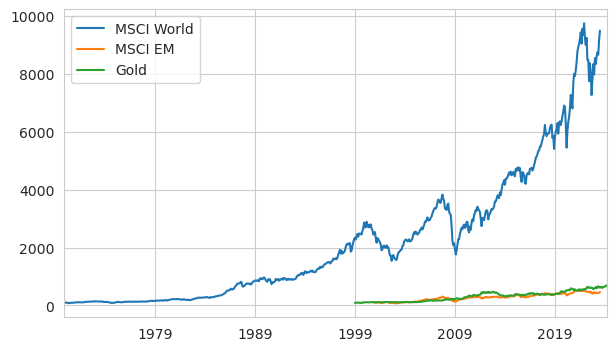

In [5]:
df.columns = names
df.plot()

In [6]:

df = df.dropna(how="any")
df

,MSCI World,MSCI EM,Gold
2000-12-01,2487.613434,100.000000,101.193012
2001-01-01,2535.516204,114.847013,104.211431
2001-02-01,2320.953678,107.036103,102.909249
2001-03-01,2168.116678,100.360134,106.549920
2001-04-01,2327.938366,105.004105,105.814740
...,...,...,...
2023-03-01,8603.222564,436.639191,590.875644
2023-04-01,8754.033498,424.828416,636.322464
2023-05-01,8666.638323,432.541944,660.972405
2023-06-01,9190.777442,438.718696,629.853480


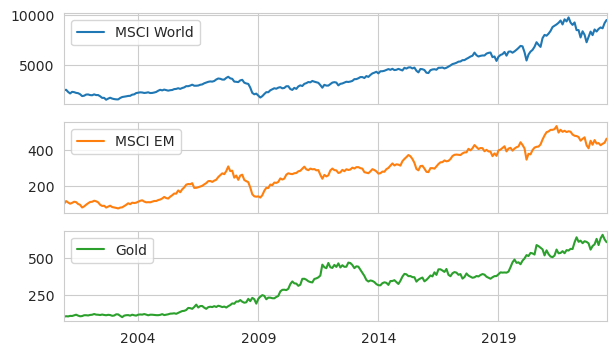

In [7]:
df.plot(subplots=True);

## Portafoglio base

In [8]:
anni = 5
pesi = np.array([0.50, 0.4, 0.10])

In [9]:
names

['MSCI World', 'MSCI EM', 'Gold']

In [10]:
ptf = (df.shift(-anni*12) / df) - 1
ptf = ptf.dropna(how="any")
ptf["RTOT"] = (ptf * pesi).sum(axis=1)
ptf.head()

,MSCI World,MSCI EM,Gold,RTOT
2000-12-01,0.114052,0.906552,0.394443,0.459091
2001-01-01,0.141811,0.792691,0.408837,0.428865
2001-02-01,0.245509,0.956758,0.563731,0.561831
2001-03-01,0.362627,1.074170,0.496046,0.660586
2001-04-01,0.307607,1.040161,0.462788,0.616147


<Axes: >

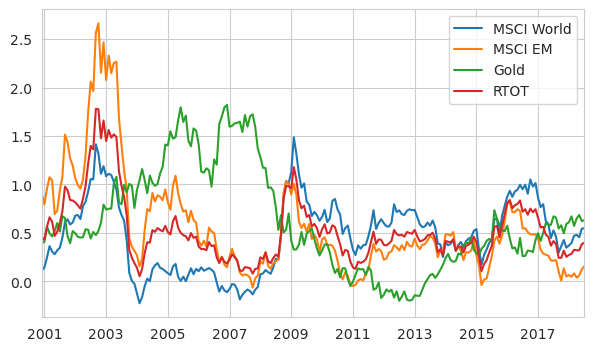

In [11]:
ptf.plot()

### Statistiche

In [12]:
ptf.RTOT.describe()

count    212.000000
mean       0.523188
std        0.331037
min        0.052478
25%        0.309698
50%        0.459208
75%        0.627832
max        1.780259
Name: RTOT, dtype: float64

VaR:

In [13]:
var = ptf.RTOT.quantile(0.05)
var

0.1404335640966622

CVaR:

In [14]:
cvar = ptf.RTOT[ptf.RTOT < var].mean()
cvar

0.11271549732625301

## Portafoglio al variare dell'allocazione

In [15]:
def get_ptf(df, anni, pesi):
    ptf = (df.shift(-anni*12) / df) - 1
    ptf = ptf.dropna(how="any")
    ptf["RTOT"] = (ptf * pesi).sum(axis=1)
    return ptf

# def ptf_stats(ptf):
#     d = ptf.RTOT.describe()
#     d["VaR"] = ptf.RTOT.quantile(0.05)
#     d["CVaR"] = ptf.RTOT[ptf.RTOT <= d.VaR].mean()
#     return d

def ptf_stats(ptf):
    d = ptf.describe()
    d.loc["VaR", :] = ptf.quantile(0.05)
    d.loc["CVaR", :] = ptf[ptf <= d.loc["VaR", :]].mean()
    return d

### Portafogli benchmark

In [16]:
ptfs = pd.DataFrame()
ptfs["RTOT_WORLD"] = get_ptf(df, anni, [1.0, 0, 0]).RTOT
ptfs["RTOT_EM"] = get_ptf(df, anni, [0.0, 1.0, 0]).RTOT
ptfs["RTOT_Gold"] = get_ptf(df, anni, [0.0, 0.0, 1.0]).RTOT

In [17]:
ptf_stats(ptfs)

,RTOT_WORLD,RTOT_EM,RTOT_Gold
count,212.000000,212.000000,212.000000
mean,0.475028,0.559241,0.619775
std,0.364495,0.531926,0.524086
min,-0.227125,-0.064029,-0.201949
25%,0.142355,0.224946,0.280256
50%,0.461234,0.389903,0.511933
75%,0.719059,0.740061,0.979152
max,1.485938,2.663560,1.820223
VaR,-0.090287,0.026634,-0.122303
CVaR,-0.136553,-0.012589,-0.169661


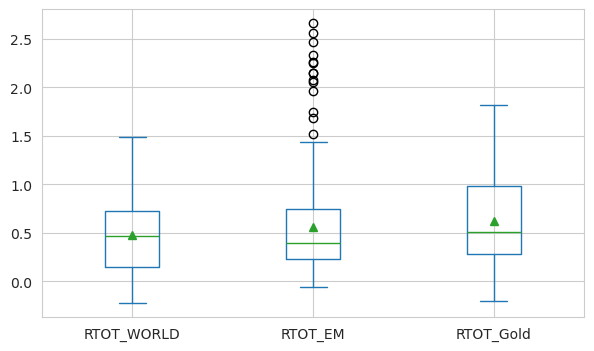

In [18]:
ptfs.plot(kind="box", showmeans=True);

## Random sampling

In [19]:
n_samples = 1000
w_12 = np.random.rand(n_samples, 2)
w_df = pd.DataFrame(w_12, columns=["w1", "w2"])
w_df = w_df[w_df.w1 + w_df.w2 <= 1]
w_df["w3"] = 1 - w_df.w1 - w_df.w2
w = w_df.to_numpy()

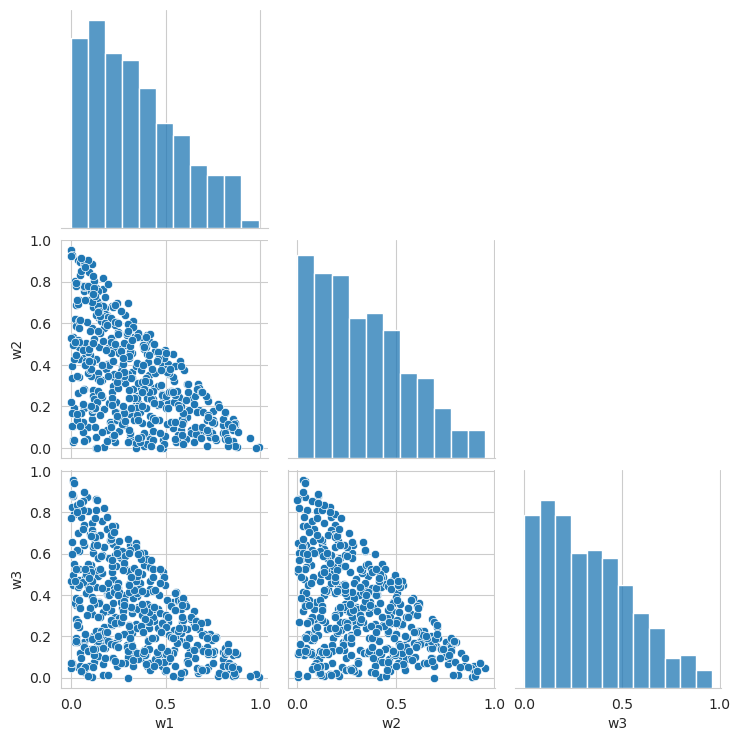

In [20]:
sns.pairplot(w_df, corner=True);

In [21]:
ptf_rnd0 = get_ptf(df, anni, w[0, :])
ptf_rnd = ptf_rnd0.RTOT.to_numpy()
ptf_rnd = np.repeat(ptf_rnd.reshape((-1, 1)), w.shape[0], axis=1)

for i in range(1, w.shape[0]):
    p = get_ptf(df, anni, w[i, :]).RTOT.to_numpy()
    ptf_rnd[:, i] = p

ptf_rnd = pd.DataFrame(ptf_rnd, index=ptf_rnd0.index)
ptf_rnd.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
2000-12-01,0.497180,0.491141,0.447973,0.568037,0.341376,0.817136,0.357789,0.466220,0.457348,0.262755,...,0.305212,0.361489,0.434840,0.535533,0.383057,0.411233,0.680202,0.358426,0.430943,0.743327
2001-01-01,0.457669,0.463073,0.428721,0.524492,0.333444,0.719446,0.357712,0.435336,0.426691,0.273316,...,0.310795,0.371034,0.436425,0.492699,0.369748,0.414258,0.609714,0.371010,0.418642,0.659111
2001-02-01,0.591522,0.604883,0.568138,0.670750,0.458464,0.876857,0.492744,0.569345,0.558921,0.395955,...,0.438788,0.514697,0.589858,0.632342,0.499626,0.563636,0.758913,0.516464,0.559935,0.811131
2001-03-01,0.702770,0.663968,0.621660,0.738600,0.550845,0.993271,0.530837,0.665002,0.661412,0.465946,...,0.495660,0.501043,0.550319,0.725832,0.581597,0.538071,0.861526,0.490266,0.593786,0.926084
2001-04-01,0.658373,0.623453,0.580431,0.699447,0.503776,0.956965,0.488409,0.620992,0.616637,0.418525,...,0.450382,0.462724,0.515952,0.683829,0.536441,0.501995,0.822656,0.452838,0.553629,0.887933


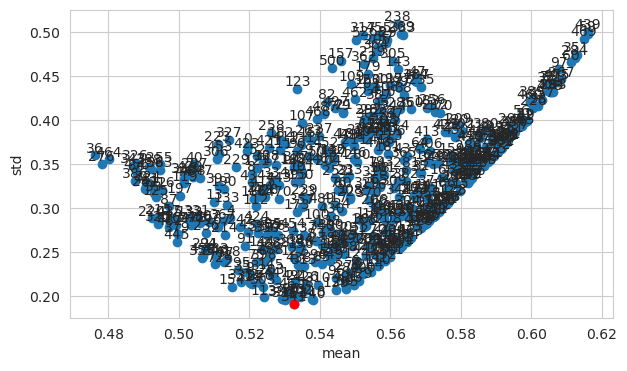

In [22]:
stats = ptf_stats(ptf_rnd)
idxmin = stats.loc["std", :].idxmin()

x = stats.loc["mean", :]
y = stats.loc["std", :]
t = stats.columns.to_numpy()
plt.figure()
plt.scatter(x, y)
plt.scatter(x[idxmin], y[idxmin], c='r')
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("mean")
plt.ylabel("std")
plt.show()

In [23]:
w[idxmin, :]

array([0.59205586, 0.0218099 , 0.38613424])

In [24]:
stats[idxmin]

count    212.000000
mean       0.532756
std        0.191659
min        0.186221
25%        0.380562
50%        0.526703
75%        0.648522
max        1.077332
VaR        0.270110
CVaR       0.236310
Name: 341, dtype: float64

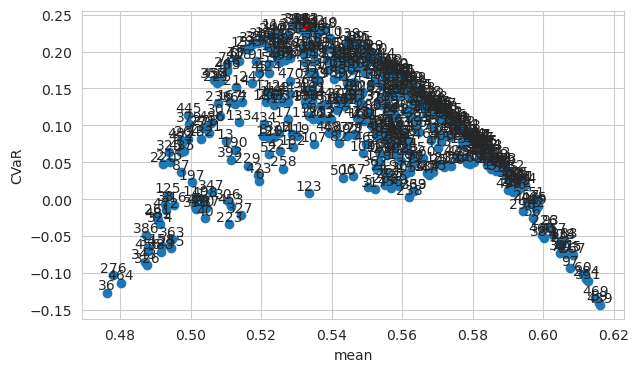

In [25]:
stats = ptf_stats(ptf_rnd)
idxmax = stats.loc["CVaR", :].idxmax()

x = stats.loc["mean", :]
y = stats.loc["CVaR", :]
t = stats.columns.to_numpy()
plt.figure()
plt.scatter(x, y)
plt.scatter(x[idxmax], y[idxmax], c='r')
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("mean")
plt.ylabel("CVaR")
plt.show()

In [26]:
w[idxmax, :]

array([0.59205586, 0.0218099 , 0.38613424])

In [27]:
stats[idxmax]

count    212.000000
mean       0.532756
std        0.191659
min        0.186221
25%        0.380562
50%        0.526703
75%        0.648522
max        1.077332
VaR        0.270110
CVaR       0.236310
Name: 341, dtype: float64

## Ottimizzazione

In [28]:
from scipy.optimize import minimize, LinearConstraint

In [ ]:
optFn = lambda w: -ptf_stats(get_ptf(df, anni, w)[["RTOT"]]).loc["CVaR", "RTOT"]
x0 = [0.0, 1.0, 0]
#x0 = [1.0, 0.0, 0]
x0 = w[idxmax, :]
constraints = (
    LinearConstraint([1, 1, 1], lb=1, ub=1),
)
bounds = [(0, 1), (0, 1), (0, 1)]

opts = {"disp": True}
sol = minimize(optFn, x0, bounds=bounds, constraints=constraints, 
    options=opts)

In [ ]:
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.2371098065049802
       x: [ 6.083e-01  8.674e-20  3.917e-01]
     nit: 4
     jac: [-2.358e-01 -2.135e-01 -2.391e-01]
    nfev: 19
    njev: 4

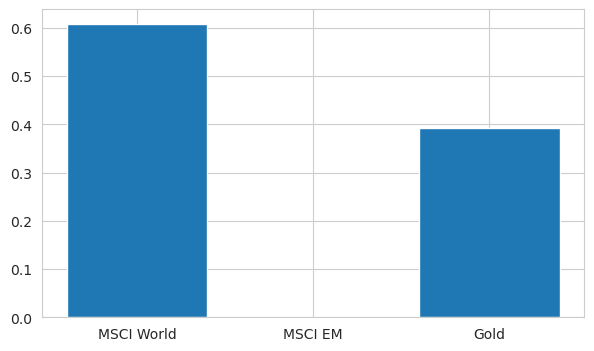

In [ ]:
plt.figure()
plt.bar(names, sol.x);

In [ ]:
pftOpt = get_ptf(df, anni, sol.x)
ptf_stats(pftOpt).RTOT

count    212.000000
mean       0.531725
std        0.187719
min        0.191824
25%        0.373671
50%        0.525029
75%        0.646102
max        1.047055
VaR        0.272348
CVaR       0.237110
Name: RTOT, dtype: float64

<Axes: >

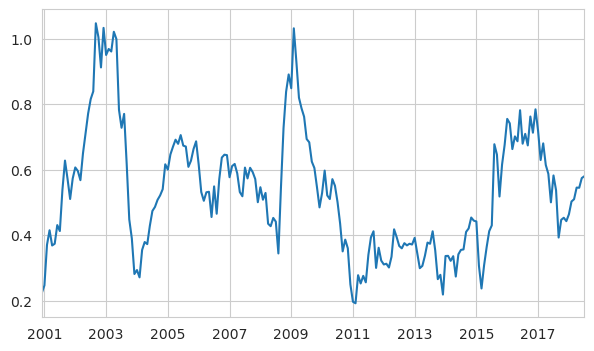

In [ ]:
pftOpt.RTOT.plot()

In [ ]:
ptfs["RTOT_Optim"] = pftOpt.RTOT

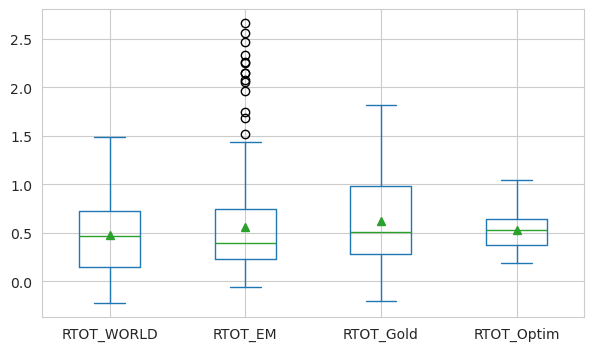

In [ ]:
ptfs.plot(kind="box", showmeans=True);

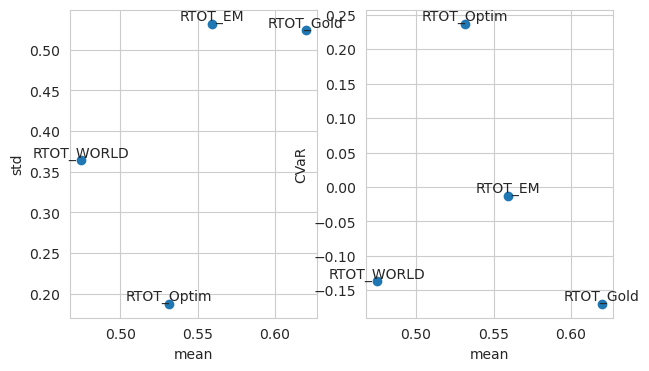

In [ ]:
stats = ptf_stats(ptfs)
x = stats.loc["mean", :]
y = stats.loc["std", :]
t = stats.columns.to_numpy()
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(x, y)
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("mean")
plt.ylabel("std")


x = stats.loc["mean", :]
y = stats.loc["CVaR", :]
t = stats.columns.to_numpy()
plt.subplot(1, 2, 2)
plt.scatter(x, y)
for (xi, yi, ti) in zip(x, y, t):
    plt.text(xi, yi, ti, va="bottom", ha="center")
plt.xlabel("mean")
plt.ylabel("CVaR")
plt.show()